In [3]:
source("~/public/SiyuanLuo/projects/benchmark/scripts/evaluation/lib_metrics.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/clustering/lib_clustering.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/func_aggregation.R", chdir=TRUE)


In [4]:
require(mbkmeans)

Loading required package: mbkmeans



In [5]:
devtools::load_all(path="~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/scFeatAgg")
devtools::reload(pkg ="~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/scFeatAgg", quiet = FALSE)

require(Signac)
require(Seurat)
require(SingleCellExperiment)


ℹ Loading scFeatAgg
Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsu

In [6]:
library(tidyr)

# Check the meta-peak clusters (PBMC)

(For protein encoding genes vs others)

In [7]:
input <- "~/public/SiyuanLuo/projects/benchmark/outputs/PBMC_multiomics/PBMC_multiomics/feature_engineering/R/aggregation/default/500/default/30.RDS"
sobj <- readRDS(input)

In [8]:
head(sobj[[DefaultAssay(sobj)]][[]])
df_features <- sobj[[DefaultAssay(sobj)]][[]]

,count,percentile,feature_groups
,<dbl>,<dbl>,<int>
chr1-9985-10251,51,0.2323341,807
chr1-180779-180978,55,0.2521977,607
chr1-181310-181570,52,0.2373054,27
chr1-191306-191746,45,0.2026995,615
chr1-267869-268178,80,0.3510154,978
chr1-271171-271388,45,0.2026995,264


In [9]:
df_features$peak <- rownames(df_features)

In [10]:
df_features <- df_features %>%
  separate(peak, c("chr", "start", "end"), sep="-")

df_features$end <- as.numeric(df_features$end)
df_features$start <- as.numeric(df_features$start)
df_features$length <- df_features$end - df_features$start

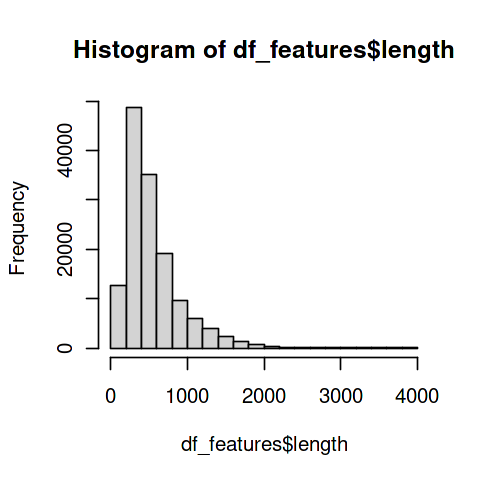

In [11]:
options(repr.plot.width=4, repr.plot.height=4)
hist(df_features$length)

In [12]:
head(df_features)

,count,percentile,feature_groups,chr,start,end,length
,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1-9985-10251,51,0.2323341,807,chr1,9985,10251,266
chr1-180779-180978,55,0.2521977,607,chr1,180779,180978,199
chr1-181310-181570,52,0.2373054,27,chr1,181310,181570,260
chr1-191306-191746,45,0.2026995,615,chr1,191306,191746,440
chr1-267869-268178,80,0.3510154,978,chr1,267869,268178,309
chr1-271171-271388,45,0.2026995,264,chr1,271171,271388,217


In [34]:
suppressPackageStartupMessages({
  library(stringr)
  library(ChIPseeker)
  library(ChIPpeakAnno)
  library(GenomicRanges)
  library(tidyverse)
  library(pheatmap)
  library(RColorBrewer)
  library(TxDb.Mmusculus.UCSC.mm10.knownGene)
  library(TxDb.Hsapiens.UCSC.hg38.knownGene)
  library(optparse)
  library(EnsDb.Hsapiens.v86)
})

In [14]:
# Calculate overlapping peaks for each mark
peakInfo <- df_features
histGR <- GRanges(gsub("chr", "", peakInfo$chr), IRanges(start = peakInfo$start, end = peakInfo$end), strand = "*")

In [15]:
histGR <- renameSeqlevels(histGR, mapSeqlevels(seqlevels(histGR), "UCSC"))

In [16]:
histGR

GRanges object with 139803 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1          9985-10251      *
       [2]     chr1       180779-180978      *
       [3]     chr1       181310-181570      *
       [4]     chr1       191306-191746      *
       [5]     chr1       267869-268178      *
       ...      ...                 ...    ...
  [139799]     chrX 155891300-155891765      *
  [139800]     chrX 155966920-155967163      *
  [139801]     chrX 155997259-155997776      *
  [139802]     chrX 156001634-156001833      *
  [139803]     chrX 156030480-156030685      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [17]:
peakAnno <- annotatePeak(histGR, tssRegion=c(-2000, 2000),
                         TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

>> preparing features information...		 2023-04-21 12:29:44 
>> identifying nearest features...		 2023-04-21 12:29:45 
>> calculating distance from peak to TSS...	 2023-04-21 12:29:46 
>> assigning genomic annotation...		 2023-04-21 12:29:46 
>> adding gene annotation...			 2023-04-21 12:30:12 


Loading required package: org.Hs.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-21 12:30:13 
>> done...					 2023-04-21 12:30:13 


In [26]:
peakAnno

Annotated peaks generated by ChIPseeker
139803/139803  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (<=1kb) 20.3407652
10   Promoter (1-2kb)  5.3339342
4              5' UTR  0.3540697
3              3' UTR  2.7066658
1            1st Exon  1.3612011
7          Other Exon  3.2724620
2          1st Intron 14.8945302
8        Other Intron 27.5358898
6  Downstream (<=300)  0.1373361
5   Distal Intergenic 24.0631460

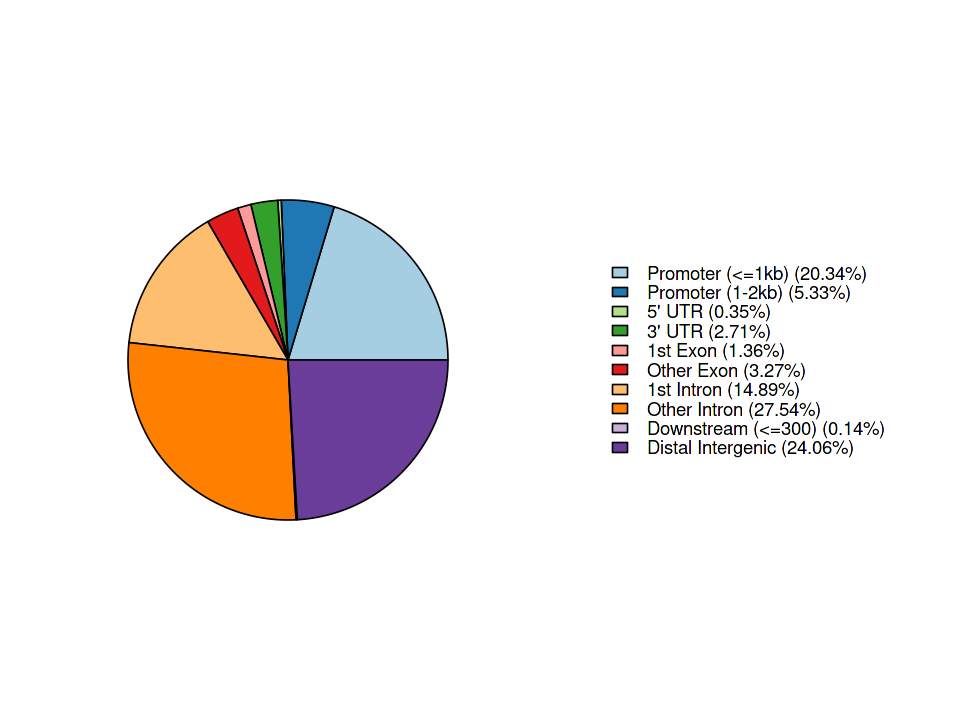

In [23]:
options(repr.plot.width=8, repr.plot.height=6)
plotAnnoPie(peakAnno)

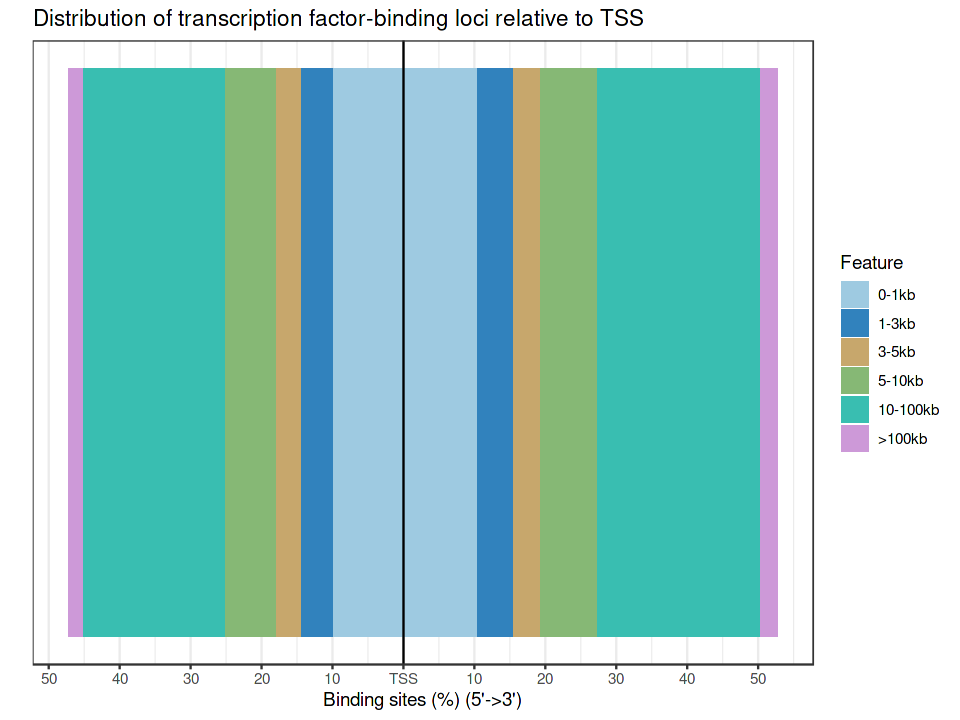

In [24]:
plotDistToTSS(peakAnno)

**Check for specific peak clusters:**

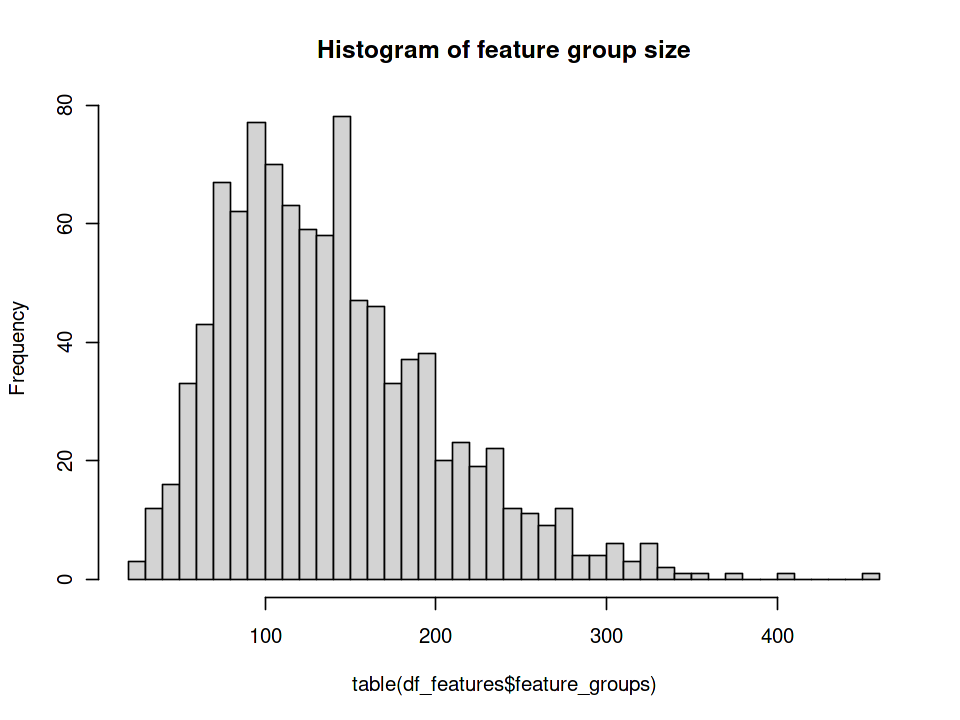

In [138]:
# group size distribution
hist(table(df_features$feature_groups), breaks=50, main="Histogram of feature group size")

In [132]:
df_features_sub <- na.omit(df_features)
dim(df_features)
dim(df_features_sub)
dim(df_features)[1] - dim(df_features_sub)[1]

[1] 139803      7

[1] 139639      7

[1] 164

**Only 164 peaks are not assigned to any peak clusters.**

## Have a look at the annotation of the first 5 clusters

>> preparing features information...		 2023-04-21 14:37:12 
>> identifying nearest features...		 2023-04-21 14:37:12 
>> calculating distance from peak to TSS...	 2023-04-21 14:37:13 
>> assigning genomic annotation...		 2023-04-21 14:37:13 
>> adding gene annotation...			 2023-04-21 14:37:16 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-21 14:37:16 
>> done...					 2023-04-21 14:37:16 
>> preparing features information...		 2023-04-21 14:37:16 
>> identifying nearest features...		 2023-04-21 14:37:16 
>> calculating distance from peak to TSS...	 2023-04-21 14:37:17 
>> assigning genomic annotation...		 2023-04-21 14:37:17 
>> adding gene annotation...			 2023-04-21 14:37:21 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-21 14:37:21 
>> done...					 2023-04-21 14:37:21 
>> preparing features information...		 2023-04-21 14:37:21 
>> identifying nearest features...		 2023-04-21 14:37:21 
>> calculating distance from peak to TSS...	 2023-04-21 14:37:21 
>> assigning genomic annotation...		 2023-04-21 14:37:21 
>> adding gene annotation...			 2023-04-21 14:37:25 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-21 14:37:25 
>> done...					 2023-04-21 14:37:25 
>> preparing features information...		 2023-04-21 14:37:25 
>> identifying nearest features...		 2023-04-21 14:37:25 
>> calculating distance from peak to TSS...	 2023-04-21 14:37:25 
>> assigning genomic annotation...		 2023-04-21 14:37:25 
>> adding gene annotation...			 2023-04-21 14:37:29 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-21 14:37:29 
>> done...					 2023-04-21 14:37:29 
>> preparing features information...		 2023-04-21 14:37:29 
>> identifying nearest features...		 2023-04-21 14:37:29 
>> calculating distance from peak to TSS...	 2023-04-21 14:37:29 
>> assigning genomic annotation...		 2023-04-21 14:37:29 
>> adding gene annotation...			 2023-04-21 14:37:33 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-21 14:37:33 
>> done...					 2023-04-21 14:37:33 


Warning message in plotAnnoBar(peakAnno_ls):
"input is not a named list, set the name automatically to Peak1 Peak2 Peak3 Peak4 Peak5"


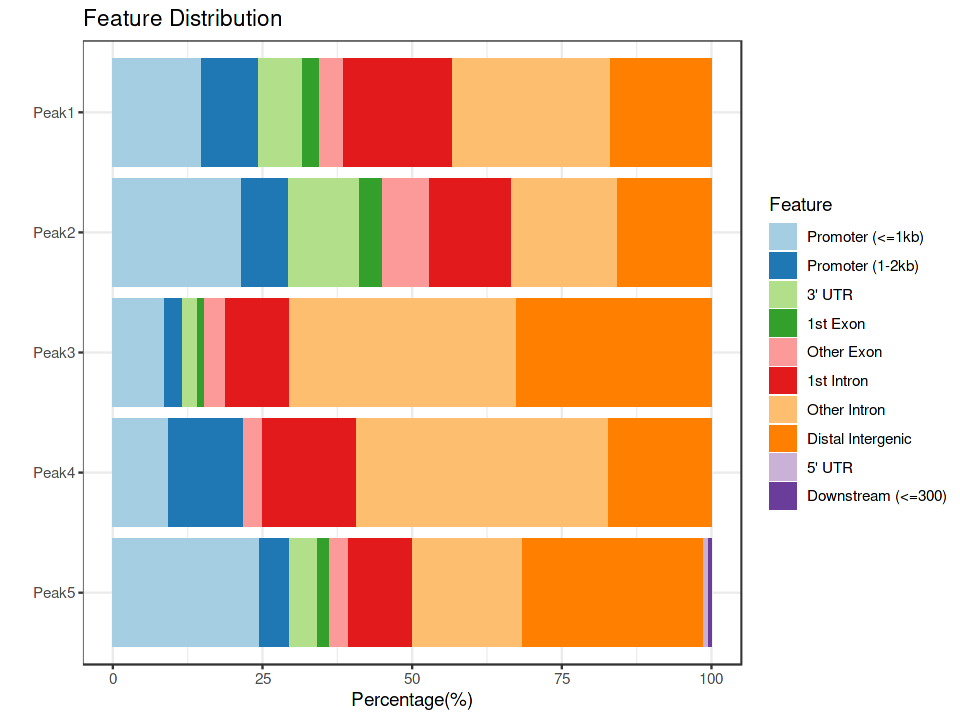

In [92]:
peakInfo_ls <- lapply(1:5, function(x){df_features_sub[df_features_sub$feature_groups==x,]})
histGR_ls <- lapply(peakInfo_ls, function(x){GRanges(gsub("chr", "", x$chr), IRanges(start = x$start, end = x$end), strand = "*")})
histGR_ls <- lapply(histGR_ls, function(x){renameSeqlevels(x, mapSeqlevels(seqlevels(x), "UCSC"))})
peakAnno_ls <- lapply(histGR_ls, function(x){annotatePeak(x, tssRegion=c(-2000, 2000),
                         TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")})
plotAnnoBar(peakAnno_ls)

In [98]:
list_to_dataframe <- function(dataList) {
    if (is.null(names(dataList)))
        return(do.call('rbind', dataList))

    cn <- lapply(dataList, colnames) %>% unlist %>% unique
    cn <- c('.id', cn)
    dataList2 <- lapply(seq_along(dataList), function(i) {
        data = dataList[[i]]
        data$.id = names(dataList)[i]
        idx <- ! cn %in% colnames(data)
        if (sum(idx) > 0) {
            for (i in cn[idx]) {
                data[, i] <- NA
            }
        }
        return(data[,cn])
    })
    res <- do.call('rbind', dataList2)
    res$.id <- factor(res$.id, levels=rev(names(dataList)))
    return(res)
}

In [100]:
plotAnnoBar.data.frame <- function(anno.df,
                                   xlab="",
                                   ylab="Percentage(%)",
                                   title="Feature Distribution",
                                   categoryColumn) {


    anno.df$Feature <- factor(anno.df$Feature, levels = rev(levels(anno.df$Feature)))

    p <- ggplot(anno.df, aes_string(x = categoryColumn,
                                    fill = "Feature",
                                    y = "Frequency"))

    p <- p + geom_bar(stat="identity") + coord_flip() + theme_bw()
    p <- p + ylab(ylab) + xlab(xlab) + ggtitle(title)

    if (categoryColumn == 1) {
        p <- p + scale_x_continuous(breaks=NULL)
        p <- p+scale_fill_manual(values=rev(getCols(nrow(anno.df))), guide=guide_legend(reverse=TRUE))
    } else {
        p <- p+scale_fill_manual(values=rev(getCols(length(unique(anno.df$Feature)))), guide=guide_legend(reverse=TRUE))
    }

    return(p)
}

In [129]:
getCols <- function(n) {
    col <- c("#8dd3c7", "#ffffb3", "#bebada",
             "#fb8072", "#80b1d3", "#fdb462",
             "#b3de69", "#fccde5", "#d9d9d9",
             "#bc80bd", "#ccebc5", "#ffed6f")

    col2 <- c("#1f78b4", "#ffff33", "#c2a5cf",
             "#ff7f00", "#810f7c", "#a6cee3",
             "#006d2c", "#4d4d4d", "#8c510a",
             "#d73027", "#78c679", "#7f0000",
             "#41b6c4", "#e7298a", "#54278f")

    col3 <- c("#a6cee3", "#1f78b4", "#b2df8a",
              "#33a02c", "#fb9a99", "#e31a1c",
              "#fdbf6f", "#ff7f00", "#cab2d6",
              "#6a3d9a", "#ffff99", "#b15928")

    ## colorRampPalette(brewer.pal(12, "Set3"))(n)
    c(col, col2, col3)[1:n]
}

In [127]:
getChrStat <- function(peakAnno){
    freq <- as.data.frame(table(peakAnno@anno@seqnames)/length(peakAnno@anno@seqnames))
    colnames(freq) <- c("Feature", "Frequency")
    return(freq)
}

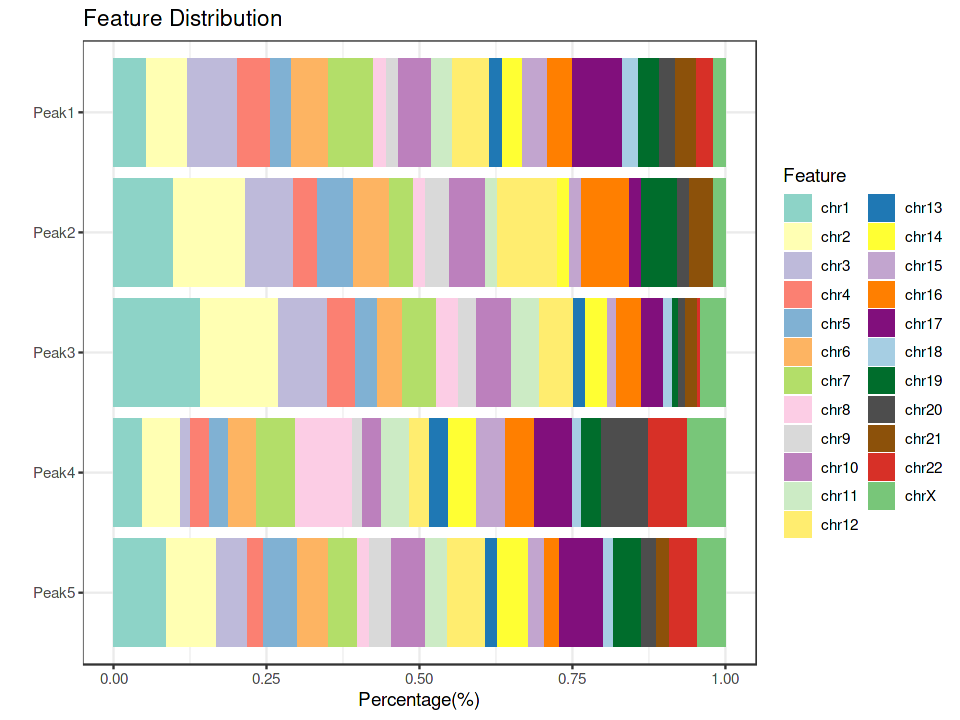

In [130]:
categoryColumn <- ".id"
if (is.null(names(peakAnno_ls))) {
                  nn <- paste0("Peak", seq_along(peakAnno_ls))
                  warning("input is not a named list, set the name automatically to ", paste(nn, collapse = " "))
                  names(peakAnno_ls) <- nn
                  ## stop("input object should be a named list...")
              }
anno <- lapply(peakAnno_ls, getChrStat)
anno.df <- list_to_dataframe(anno)
plotAnnoBar.data.frame(anno.df, xlab="", ylab='Percentage(%)', title="Feature Distribution", categoryColumn)

In [131]:
head(as.data.frame(peakAnno@anno))

,seqnames,start,end,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,chr1,22075660,22076170,511,*,Promoter (<=1kb),1,22076334,22092942,16609,1,998,ENST00000695802.1,-164,ENSG00000070831,CDC42,cell division cycle 42
2,chr1,26932058,26932906,849,*,"Intron (ENST00000435827.6/10726, intron 4 of 6)",1,26922142,26942776,20635,1,10726,ENST00000452707.1,9916,ENSG00000090273,NUDC,"nuclear distribution C, dynein complex regulator"
3,chr1,27369418,27370059,642,*,"Exon (ENST00000270879.9/8547, exon 8 of 8)",1,27355184,27366961,11778,2,9064,ENST00000357582.3,-2457,ENSG00000142733,MAP3K6,mitogen-activated protein kinase kinase kinase 6
4,chr1,76075633,76076321,689,*,Promoter (<=1kb),1,76074746,76634603,559858,1,256435,ENST00000328299.4,887,ENSG00000184005,ST6GALNAC3,"ST6 N-acetylgalactosaminide alpha-2,6-sialyltransferase 3"
5,chr1,220887424,220888206,783,*,Distal Intergenic,1,220881069,220884493,3425,1,3142,ENST00000427693.1,6355,ENSG00000136630,HLX,H2.0 like homeobox
6,chr1,230169572,230170065,494,*,"Intron (ENST00000494106.1/2590, intron 1 of 6)",1,230255358,230282120,26763,1,2590,ENST00000485438.1,-85293,ENSG00000143641,GALNT2,polypeptide N-acetylgalactosaminyltransferase 2


## Check the gene biotype in this database:

In [49]:
ENTREZID_TxDb <- keys(TxDb.Hsapiens.UCSC.hg38.knownGene, keytype = "GENEID")
ENTREZID_TxDb_df <- data.frame(ENTREZID = as.character(ENTREZID_TxDb), Entrez_TxDb = as.integer(ENTREZID_TxDb))

In [36]:
keytypes(EnsDb.Hsapiens.v86)

[1] "ENTREZID"            "EXONID"              "GENEBIOTYPE"        
 [4] "GENEID"              "GENENAME"            "PROTDOMID"          
 [7] "PROTEINDOMAINID"     "PROTEINDOMAINSOURCE" "PROTEINID"          
[10] "SEQNAME"             "SEQSTRAND"           "SYMBOL"             
[13] "TXBIOTYPE"           "TXID"                "TXNAME"             
[16] "UNIPROTID"

In [40]:
ENSEMBL_EnsDb <- keys(EnsDb.Hsapiens.v86, keytype = "GENEID")
gene_dataframe_EnsDb <- ensembldb::select(EnsDb.Hsapiens.v86, keys=ENSEMBL_EnsDb, 
                                          columns=c("ENTREZID", "SYMBOL", "GENEBIOTYPE"), keytype="GENEID")
colnames(gene_dataframe_EnsDb) <- c("Ensembl", "Entrez", "HGNC", "GENEBIOTYPE")
colnames(gene_dataframe_EnsDb) <- paste(colnames(gene_dataframe_EnsDb), "EnsDb", sep = "_")
# additional column with HGNC added for merging & keeping one copy of it in the merged dataframe
gene_dataframe_EnsDb$HGNC <- gene_dataframe_EnsDb$HGNC_EnsDb

In [41]:
head(gene_dataframe_EnsDb)

,Ensembl_EnsDb,Entrez_EnsDb,HGNC_EnsDb,GENEBIOTYPE_EnsDb,HGNC
,<chr>,<int>,<chr>,<chr>,<chr>
1,ENSG00000000003,7105,TSPAN6,protein_coding,TSPAN6
2,ENSG00000000005,64102,TNMD,protein_coding,TNMD
3,ENSG00000000419,8813,DPM1,protein_coding,DPM1
4,ENSG00000000457,57147,SCYL3,protein_coding,SCYL3
5,ENSG00000000460,55732,C1orf112,protein_coding,C1orf112
6,ENSG00000000938,2268,FGR,protein_coding,FGR


In [55]:
head(ENTREZID_TxDb_df)
dim(ENTREZID_TxDb_df)

,ENTREZID,Entrez_TxDb
,<chr>,<int>
1,1,1
2,10,10
3,100,100
4,1000,1000
5,10000,10000
6,100008586,100008586


[1] 31456     2

In [58]:
# merging the two dataframes 
gene_dataframe <- inner_join(gene_dataframe_EnsDb, ENTREZID_TxDb_df, by = c("Entrez_EnsDb" = "Entrez_TxDb")) 

In [59]:
head(gene_dataframe)
dim(gene_dataframe)

,Ensembl_EnsDb,Entrez_EnsDb,HGNC_EnsDb,GENEBIOTYPE_EnsDb,HGNC,ENTREZID
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000000003,7105,TSPAN6,protein_coding,TSPAN6,7105
2,ENSG00000000005,64102,TNMD,protein_coding,TNMD,64102
3,ENSG00000000419,8813,DPM1,protein_coding,DPM1,8813
4,ENSG00000000457,57147,SCYL3,protein_coding,SCYL3,57147
5,ENSG00000000460,55732,C1orf112,protein_coding,C1orf112,55732
6,ENSG00000000938,2268,FGR,protein_coding,FGR,2268


[1] 28513     6

In [60]:
table(gene_dataframe$GENEBIOTYPE_EnsDb)


          3prime_overlapping_ncRNA                          antisense 
                                 2                               1206 
     bidirectional_promoter_lncRNA                          IG_V_gene 
                                 1                                  1 
                           lincRNA                           LRG_gene 
                              1737                                677 
                             miRNA                           misc_RNA 
                              1547                                  8 
                        non_coding             polymorphic_pseudogene 
                                 2                                 48 
              processed_pseudogene               processed_transcript 
                                18                                343 
                    protein_coding                         pseudogene 
                             21897                                  1 
     

## Characterizing the feature count matrix